
# **Optimal Personnel Allocation for Temporary Hospitals**

- **Leire Pantoja Jiménez**
- **NIA: 100452928**




## Libraries

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.1 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package

In [ ]:
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import value
from matplotlib.cm import get_cmap
import networkx as nx
from collections import defaultdict
import time

## **Introduction**


The 2014 Ebola outbreak in West Africa marked one of the most severe health crises in recent history, disproportionately impacting Guinea, Sierra Leone, and Liberia. The rapid spread of the virus overwhelmed local healthcare systems, creating an urgent need for additional medical personnel to support treatment efforts and contain the outbreak.

As an organization dedicated to emergency response, our goal was to allocate healthcare professionals from our resource bases to the most affected temporary hospitals effectively and efficiently. This task involved managing a complex network of resources, limited availability of personnel, and logistical challenges, while ensuring the well-being of deployed staff.

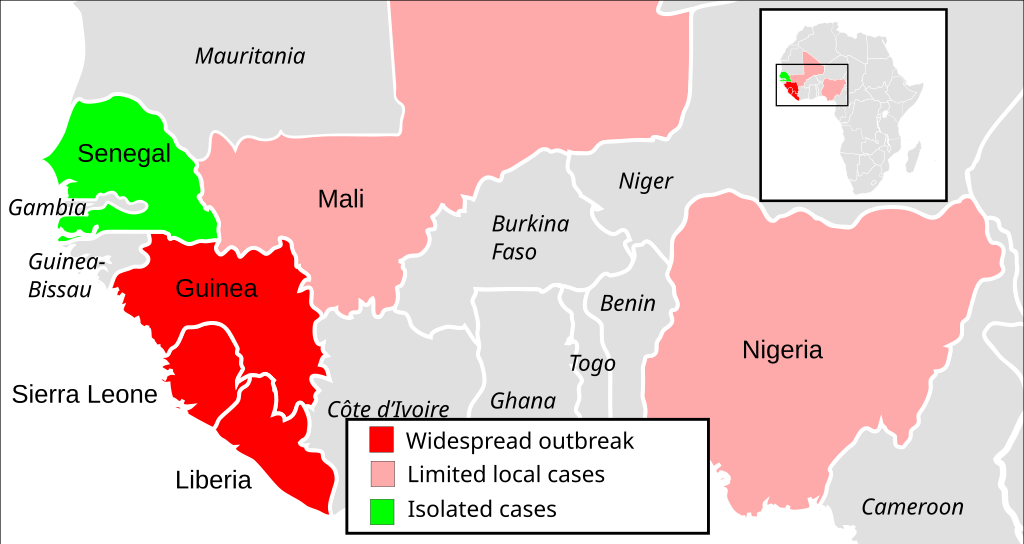

## **a) Linear optimization problem**

In order to save lives and provide the necessary medical care, the organization must deploy personnel from its resource bases in the critical countries to hospitals in disaster-stricken areas. These deployments must be carried out while minimizing the associated costs and risks.

The model involves several key components, including sets, parameters, decision variables, the objective function, and constraints. Its primary objective is to minimize the total deployment cost of personnel to hospitals, considering three main factors: the cost of assigning personnel, transportation costs based on distance, and the risk associated with transportation. The decision variables represent the number of personnel of each type (doctors, nurses, and technicians) assigned from each base to each hospital.

The model includes constraints to ensure that personnel requirements at hospitals are met, the availability of personnel at each base is respected, the capacities of hospitals are not exceeded, and the proportionality of personnel types (doctors, nurses, technicians) is maintained across hospitals. Additionally, it ensures that no base exceeds its available personnel and that the total number of personnel assigned to any hospital does not exceed its capacity.

\
 **SETS:**
- $B:$ set of bases, indexed by $i$, $B = \{1,2,3,4,5\}$

- $H:$ set of hospitals, indexed by $j $, $H = \{1,2, ..., 10\}$

- $T:$ set of personnel types, $T = \{doctors, nurses, technicians\}$

\
 **PARAMETERS**
- $c_{ijt}:$ deployment cost per professional of type $t$ from base $i$ to hospital $j$

- $R_{jt}:$ Minimum number of personal of type $t$ required at hospital $j$

- $A_{it}:$ Maximum number of personnel of type $t$ available at base $i$

- $C_j:$ Maximum total personnel capacity of hospital $j$

- $d_{ij}:$ Distance in kilometers from base $i$ to hospital $j$

- $r_{ij}:$ Risk factor associated with transporting personnel from base $i$ to hospital $j$



\
 **DECISION VARIABLES**
- $x_{ijt}:$ Number of proffesionals of type $t$ assisned from base $i$ to hospital $j$

\
 **OBJECTIVE FUNCTION**

The objective of the model is to minimize the total deployment cost. This includes:

- The cost of assigning personnel from the bases to the hospitals

- The transportation costs based on the distance between bases and hospitals

- The risk cost associated with transporting personnel

\
$$
\text{Minimize} \quad Z = \sum_{i \in B} \sum_{j \in H} \sum_{t \in T} \left( c_{ijt} \cdot x_{ijt} + d_{ij} \cdot \text{travel_cost_factor} \cdot x_{ijt} + r_{ij} \cdot \text{risk_factor} \cdot x_{ijt} \right)
$$


**CONSTRAINS**

- Each hospital $j$ must meet the minimum requirement of personnel for each type $t$

$$
\sum_{i \in B} x_{ijt} \geq R_{jt}, \quad \forall j \in H, \forall t \in T
$$

- The personnel assigned from each base $i$ cannot exceed its availability:

$$
\sum_{j \in H} x_{ijt} \leq A_{it}, \quad \forall i \in B, \forall t \in T
$$

- The total personnel assigned to a hospital $j$ must not exceed its capacity:

$$
\sum_{i \in B} \sum_{t \in T} x_{ijt} \leq C_j, \quad \forall j \in H
$$


- At least one person of each type in each hospital assigned:
$$
\sum_{i \in B} x_{ijt} \geq 1, \quad \forall j \in H, \forall t \in T
$$

- The decision variables must be non-negative integers:

$$
x_{ijt} \geq 0 \quad \text{and} \quad x_{ijt} \in \mathbb{Z}, \quad \forall i \in B, \forall j \in H, \forall t \in T
$$


**CHECK PROBLEM SIZE**

The number of **decision variables** is given by:

$$
|B| \cdot |H| \cdot |T| = 5 \cdot 10 \cdot 3 = 150
$$

The number of **constrains** is given by:

Personel  requirement:

$$
|H| \cdot |T| = 10 \cdot 3 = 30
$$

Personel availability:

$$
|B| \cdot |T| = 5 \cdot 3 = 15
$$

Hospital capacities:
$$
|H| = 10
$$

At least one person of each type in each hospital:

$$
|H| ⋅ |T| = 10 ⋅ 3 = 30
$$

Total Constraints:
$$
30 + 15 + 10  + 30 = 85
$$



## **b) Solving with Pyomo**

Now we solve the problem using the library Pyomo. First of all we create the function which will receive the parameters and give the output with the result.

In [ ]:
def personnel_allocation(I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor, return_duals=False):
    """
    Function to solve the personnel allocation problem.

    Parameters:
    - I: List of bases.
    - J: List of hospitals.
    - personnel_types: Types of personnel.
    - costs: Personnel costs (3D matrix).
    - availability: Availability at bases.
    - requirements: Minimum personnel requirements per hospital.
    - capacities: Maximum capacity per hospital.
    - proportions: Proportions between personnel roles.
    - distances: Distances between bases and hospitals.
    - risks: Risks associated with transportation.
    - travel_cost_factor: Travel cost factor.
    - risk_factor: Risk factor.
    - return_duals: Boolean, whether to return dual values.

    Returns:
    - results: Results of the model solution.
    - model: The solved model.
    - optimal_value: Optimal value of the objective function.
    - assignments: Dictionary of optimal personnel assignments.
    - duals (optional): Dictionary of dual values for the constraints.
    """
    # Create model
    model = pyo.ConcreteModel(name="Personnel Allocation")

    # Sets
    model.I = pyo.Set(initialize=I)
    model.J = pyo.Set(initialize=J)
    model.T = pyo.Set(initialize=personnel_types)

    # Variables
    model.x = pyo.Var(model.I, model.J, model.T, domain=pyo.NonNegativeReals)

    # Objective function
    def obj_expression(model):
        return sum(
            costs[i-1, j-1, t_idx] * model.x[i, j, t] +
            distances[(i, j)] * travel_cost_factor * model.x[i, j, t] +
            risks[(i, j)] * risk_factor * model.x[i, j, t]
            for i in model.I for j in model.J for t_idx, t in enumerate(model.T)
        )
    model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.minimize)

    # Constraints

    # 1. Minimum personnel
    def req_constraint_rule(model, j, t):
        return sum(model.x[i, j, t] for i in model.I) >= requirements[j][t]
    model.req_Constraint = pyo.Constraint(model.J, model.T, rule=req_constraint_rule)

    # 2. Availability at bases
    def avail_constraint_rule(model, i, t):
        return sum(model.x[i, j, t] for j in model.J) <= availability[i][t]
    model.avail_Constraint = pyo.Constraint(model.I, model.T, rule=avail_constraint_rule)

    # 3. Maximum capacity per hospital
    def cap_constraint_rule(model, j):
        return sum(model.x[i, j, t] for i in model.I for t in model.T) <= capacities[j]
    model.cap_Constraint = pyo.Constraint(model.J, rule=cap_constraint_rule)

    # 4. At least one person of each type in each assigned hospital
    def min_personnel_constraint_rule(model, j):
        return sum(model.x[i, j, t] for i in model.I for t in model.T) >= 1
    model.min_personnel_Constraint = pyo.Constraint(model.J, rule=min_personnel_constraint_rule)

    # Solve model
    model.dual = Suffix(direction=Suffix.IMPORT)
    opt = pyo.SolverFactory('glpk')
    results = opt.solve(model, tee=True)

    # Ensure the model is solved
    if (results.solver.status != pyo.SolverStatus.ok) or (results.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise ValueError("Solver did not find an optimal solution.")

    # Extract results
    optimal_value = pyo.value(model.OBJ)
    assignments = {
        (i, j, t): model.x[i, j, t].value
        for i in model.I for j in model.J for t in model.T if model.x[i, j, t].value > 0
    }

    # Calculate duals
    duals = {
        constraint.name: {key: model.dual[constraint[key]] for key in constraint}
        for constraint in [model.req_Constraint, model.avail_Constraint, model.cap_Constraint,model.min_personnel_Constraint]
        if constraint.active
    }


    # Decide what to return
    if return_duals:
        return results, model, optimal_value, assignments, duals
    else:
        return results, model, optimal_value, assignments


### **Numerical Analysis**

Once the model is created we can do a numerical analysis of the problem for a given set of parameters.

In [ ]:
np.random.seed(2)
I = range(1, 6)  # 5 bases
J = range(1, 11)  # 10 hospitals
personnel_types = ['doctors', 'nurses', 'technicians']

# Parameters

# Costs of personnel
costs = np.random.randint(50, 200, size=(len(I), len(J), len(personnel_types)))

# Availability in bases
availability = {
    1: {'doctors': 40, 'nurses': 50, 'technicians': 40},
    2: {'doctors': 30, 'nurses': 40, 'technicians': 30},
    3: {'doctors': 30, 'nurses': 40, 'technicians': 30},
    4: {'doctors': 20, 'nurses': 30, 'technicians': 20},
    5: {'doctors': 20, 'nurses': 30, 'technicians': 20}
}

# Minimum requirements in hospitals
requirements = {
    1: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    2: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    3: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    4: {'doctors': 5, 'nurses': 8, 'technicians': 6},
    5: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    6: {'doctors': 6, 'nurses': 10, 'technicians': 8},
    7: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    8: {'doctors': 5, 'nurses': 8, 'technicians': 6},
    9: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    10: {'doctors': 4, 'nurses': 6, 'technicians': 4}
}

# Maximum capacity per hospital
capacities = {
    1: 50, 2: 50, 3: 50, 4: 40, 5: 50,
    6: 50, 7: 50, 8: 50, 9: 50, 10: 40
}


# Distances between bases and hospitals
distances = {
    (i, j): np.random.randint(1000, 5000) for i in I for j in J
}

# Risk associated with transport
risks = {
    (i, j): np.random.uniform(0.1, 1.0) for i in I for j in J
}

# Travel factor cost
travel_cost_factor = 0.5

# Risk Factor
risk_factor = 50



In [ ]:
results, model, optimal_value, assignments, duals = personnel_allocation(
    I, J, personnel_types, costs, availability, requirements, capacities,
     distances, risks, travel_cost_factor, risk_factor,
    return_duals=True
)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpfuzfxpuc.glpk.raw --wglp /tmp/tmp8kbk7c4a.glpk.glp --cpxlp
 /tmp/tmpnkx13yi4.pyomo.lp
Reading problem data from '/tmp/tmpnkx13yi4.pyomo.lp'...
65 rows, 150 columns, 600 non-zeros
1104 lines were read
Writing problem data to '/tmp/tmp8kbk7c4a.glpk.glp'...
1033 lines were written
GLPK Simplex Optimizer 5.0
65 rows, 150 columns, 600 non-zeros
Preprocessing...
65 rows, 150 columns, 600 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 65
      0: obj =   0.000000000e+00 inf =   2.240e+02 (40)
     46: obj =   3.790364141e+05 inf =   0.000e+00 (0)
*    79: obj =   2.075790699e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (199053 bytes)
Writing basic solution to '/tmp/tmpfuzfxpuc.glpk.raw'...
224 lines were written


The solver has found an optimal solution at iteration 79.

#### **Optimal value**

The optimal value for the given set of parameters is **207,579.06€** meaning that the objective function will minimize the total cost while satisfying all the constrains.

In [ ]:
print(f"Optimal Objective Value: {optimal_value}")


Optimal Objective Value: 207579.06988344862


Now we can see how the personnel has been distributed and if the constrains have been satisfied.

In [ ]:
print("Assignments:")
for key, value in assignments.items():
    print(f"Base {key[0]} -> Hospital {key[1]} ({key[2]}): {value}")

Assignments:
Base 2 -> Hospital 3 (doctors): 5.0
Base 2 -> Hospital 3 (nurses): 10.0
Base 2 -> Hospital 3 (technicians): 8.0
Base 2 -> Hospital 5 (doctors): 5.0
Base 2 -> Hospital 5 (nurses): 10.0
Base 2 -> Hospital 5 (technicians): 8.0
Base 2 -> Hospital 7 (doctors): 5.0
Base 2 -> Hospital 7 (nurses): 10.0
Base 2 -> Hospital 7 (technicians): 8.0
Base 2 -> Hospital 9 (technicians): 2.0
Base 3 -> Hospital 2 (doctors): 5.0
Base 3 -> Hospital 2 (nurses): 10.0
Base 3 -> Hospital 2 (technicians): 8.0
Base 3 -> Hospital 6 (doctors): 6.0
Base 3 -> Hospital 6 (nurses): 10.0
Base 3 -> Hospital 6 (technicians): 8.0
Base 4 -> Hospital 1 (doctors): 5.0
Base 4 -> Hospital 1 (nurses): 10.0
Base 4 -> Hospital 1 (technicians): 8.0
Base 4 -> Hospital 8 (doctors): 5.0
Base 4 -> Hospital 8 (nurses): 8.0
Base 4 -> Hospital 8 (technicians): 6.0
Base 4 -> Hospital 9 (doctors): 5.0
Base 4 -> Hospital 9 (nurses): 10.0
Base 4 -> Hospital 9 (technicians): 6.0
Base 5 -> Hospital 4 (doctors): 5.0
Base 5 -> Hospit

In [ ]:
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("OPTIMAL SOLUTION FOUND")
    data = {'Base': [], 'Hospital': [], 'Personnel': [], 'Quantity': []}
    for i in model.I:
        for j in model.J:
            for t in model.T:
                allocation = pyo.value(model.x[i, j, t])
                if allocation > 0:
                    data['Base'].append(i)
                    data['Hospital'].append(j)
                    data['Personnel'].append(t)
                    data['Quantity'].append(allocation)

    df = pd.DataFrame(data)

    pivot_table = df.pivot_table(
        values='Quantity',
        index='Hospital',
        columns='Personnel',
        aggfunc='sum',
        fill_value=0
    )
    print("\nPivot Table (Summary of Personnel by Hospital):")
    print(pivot_table)
else:
    print("NO OPTIMAL SOLUTION FOUND.")


OPTIMAL SOLUTION FOUND

Pivot Table (Summary of Personnel by Hospital):
Personnel  doctors  nurses  technicians
Hospital                               
1              5.0    10.0          8.0
2              5.0    10.0          8.0
3              5.0    10.0          8.0
4              5.0     8.0          6.0
5              5.0    10.0          8.0
6              6.0    10.0          8.0
7              5.0    10.0          8.0
8              5.0     8.0          6.0
9              5.0    10.0          8.0
10             4.0     6.0          4.0


In [ ]:
model.display()

Model Personnel Allocation

  Variables:
    x : Size=150, Index=I*J*T
        Key                    : Lower : Value : Upper : Fixed : Stale : Domain
             (1, 1, 'doctors') :     0 :   0.0 :  None : False : False : NonNegativeReals
              (1, 1, 'nurses') :     0 :   0.0 :  None : False : False : NonNegativeReals
         (1, 1, 'technicians') :     0 :   0.0 :  None : False : False : NonNegativeReals
             (1, 2, 'doctors') :     0 :   0.0 :  None : False : False : NonNegativeReals
              (1, 2, 'nurses') :     0 :   0.0 :  None : False : False : NonNegativeReals
         (1, 2, 'technicians') :     0 :   0.0 :  None : False : False : NonNegativeReals
             (1, 3, 'doctors') :     0 :   0.0 :  None : False : False : NonNegativeReals
              (1, 3, 'nurses') :     0 :   0.0 :  None : False : False : NonNegativeReals
         (1, 3, 'technicians') :     0 :   0.0 :  None : False : False : NonNegativeReals
             (1, 4, 'doctors') :     0 

Here we can see how the model perform the allocation. The value of the objective function is the one we mentioned before: **207,579.06€**, which represents the outcome of the optimization process under the given contrains. Is the minimum budget needed to perform the operation in Africa.

- **Minimum Personnel Requirements:** Each hospital is required to have a certain number of personnel by type (doctors, nurses, and technicians). For example, hospital 1 requires 5 doctors, 10 nurses, and 8 technicians. The results show that these minimum requirements are being met for each hospital, as the "Body" column for each constraint matches the "Lower" value, indicating that the solution respects the constraints.

- **Availability at Bases:** The availability of personnel at each base is constrained by the number of personnel available per base and per type. For example, Base 1 has a maximum of 40 doctors available, with the "Body" column reflecting the actual number of doctors allocated (in this case, 0). This shows that the solution stays within the available personnel capacity for each base.

- **Maximum Capacity per Hospital:** Each hospital has a maximum capacity for personnel, which is also respected. For instance, hospital 1 has a maximum of 50 personnel, and the total personnel allocated to it is 23, which is within the limit. The results indicate that the solution adheres to the hospital capacity constraints.

- **At Least One Personnel of Each Type in Each Assigned Hospital:** The model also ensures that each hospital has at least one personnel from each type (doctor, nurse, technician) assigned to it. For example, hospital 1 has 23 personnel in total, which satisfies the minimum requirement for personnel of each type. This constraint ensures that each hospital is adequately staffed across all personnel categories.

We can create a pivot table to summarize the results of the allocations and a graphs to visualize it.

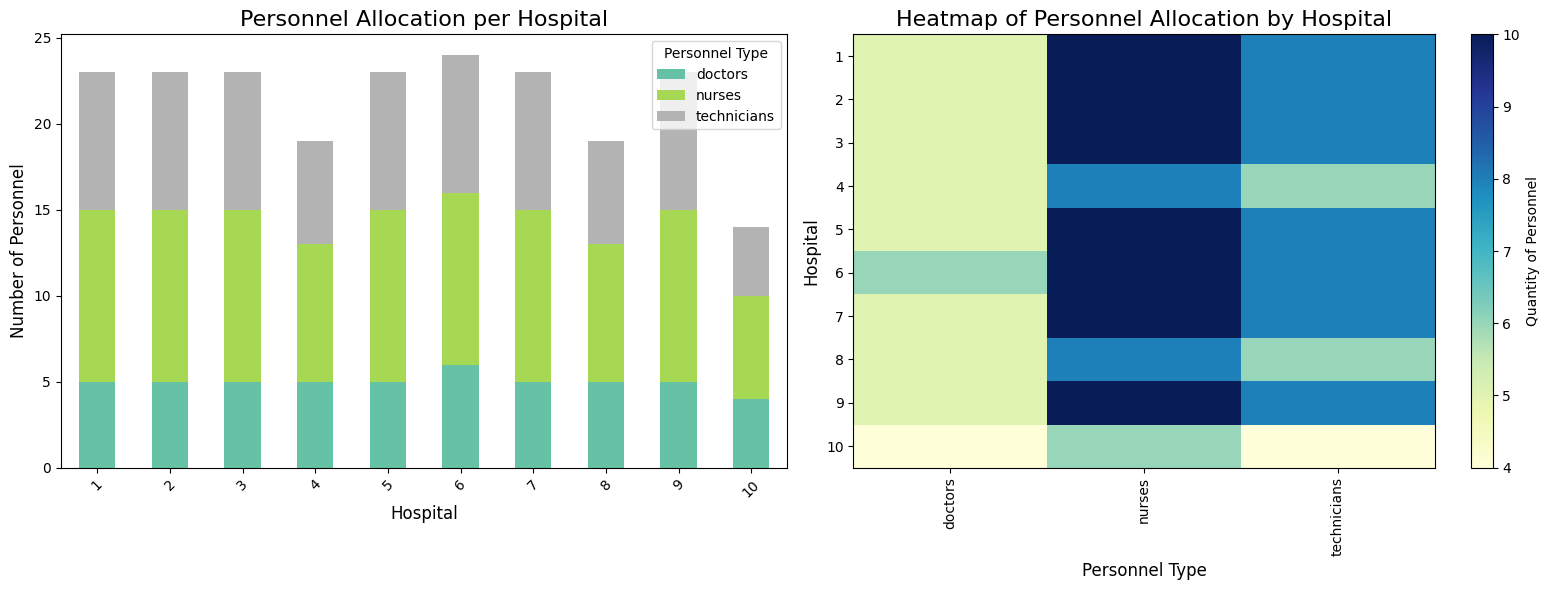

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

pivot_table.plot(kind='bar', stacked=True, colormap='Set2', ax=ax[0])
ax[0].set_title("Personnel Allocation per Hospital", fontsize=16)
ax[0].set_xlabel("Hospital", fontsize=12)
ax[0].set_ylabel("Number of Personnel", fontsize=12)
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(title='Personnel Type')


heatmap_data = df.pivot_table(values='Quantity', index='Hospital', columns='Personnel', aggfunc='sum', fill_value=0)
cax = ax[1].imshow(heatmap_data.values, cmap='YlGnBu', aspect='auto', interpolation='nearest')
plt.colorbar(cax, ax=ax[1], label='Quantity of Personnel')
ax[1].set_xticks(np.arange(len(heatmap_data.columns)))
ax[1].set_xticklabels(heatmap_data.columns, rotation=90)
ax[1].set_yticks(np.arange(len(heatmap_data.index)))
ax[1].set_yticklabels(heatmap_data.index)
ax[1].set_title('Heatmap of Personnel Allocation by Hospital', fontsize=16)
ax[1].set_xlabel('Personnel Type', fontsize=12)
ax[1].set_ylabel('Hospital', fontsize=12)

plt.tight_layout()
plt.show()


We can see that some hospitals (for example , Hospital 4 and Hospital 10) have **fewer total personnel** compared to others due to the data restrictions.

The heatmap provides a visual overview of the quantity of each personnel type allocated to each hospital. The color intensity represents the number of personnel, with darker shades indicating higher allocations. Specific hospitals (for example, Hospital 10) have a low number of nurses compared to others, possibly reflecting higher demand for nursing staff.

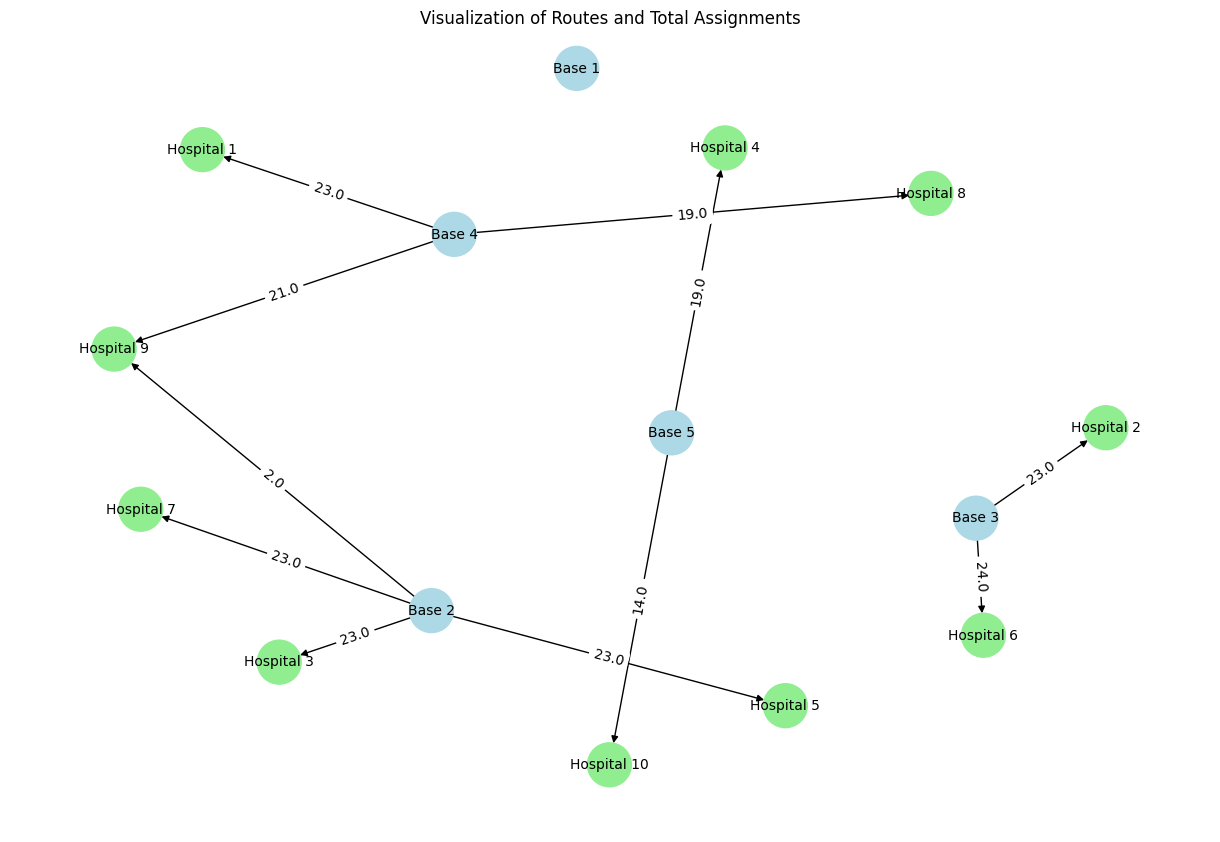

In [ ]:
def visualize_routes_and_assignments(assignments, I, J, personnel_types):
    """
    Visualizes the routes and total assignments between bases and hospitals.

    Parameters:
    - assignments: Dictionary of optimal assignments (from the model).
    - I: List of bases.
    - J: List of hospitals.
    - personnel_types: Types of personnel (e.g., doctors, nurses, technicians).
    """
    G = nx.DiGraph()

    for i in I:
        G.add_node(f"Base {i}", color='lightblue')
    for j in J:
        G.add_node(f"Hospital {j}", color='lightgreen')

    for i in I:
        for j in J:
            total_assignment = sum(assignments.get((i, j, t), 0) for t in personnel_types)
            if total_assignment > 0:
                G.add_edge(f"Base {i}", f"Hospital {j}", weight=total_assignment)

    node_colors = [data['color'] for _, data in G.nodes(data=True)]

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=10)

    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

    plt.title("Visualization of Routes and Total Assignments")
    plt.show()

# Visualize the results
visualize_routes_and_assignments(assignments, I, J, personnel_types)


Each node in the graph represents either a base (in light blue) or a hospital (in light green). The edges connecting the nodes indicate the routes where personnel are assigned, with the numbers on the edges representing the total number of personnel assigned for that route.

## **c) Sensitivity analysis**

In this section we make a **sensitivity analysis** as it is a critical step in understanding the behavior of an optimization model. It evaluates how **changes in the model's constrain affect the optimal solution** and the objective value. By analyzing the sensitivity values (or dual values), we can identify which constraints are active and which resources are critical to the solution.

In [ ]:
def format_duals(duals):
    formatted_tables = {}
    for constraint_name, values in duals.items():
        if all(isinstance(key, tuple) for key in values.keys()):
            df = pd.DataFrame.from_dict(values, orient="index", columns=["Dual Value"])
            df.index = pd.MultiIndex.from_tuples(
                df.index,
                names=[f"Index {i+1}" for i in range(len(next(iter(values.keys()))))]
            )
        else:
            df = pd.DataFrame.from_dict(values, orient="index", columns=["Dual Value"])
            df.index.name = "Index"
        formatted_tables[constraint_name] = df
    return formatted_tables


In [ ]:
formatted_duals = format_duals(duals)
avail_table = formatted_duals.get("avail_Constraint")
print("--- Sensitivity -  Availability ---")
print(avail_table)

--- Sensitivity -  Availability ---
                     Dual Value
Index 1 Index 2                
1       doctors        0.000000
        nurses         0.000000
        technicians    0.000000
2       doctors        0.000000
        nurses         0.000000
        technicians    0.000000
3       doctors        0.000000
        nurses         0.000000
        technicians    0.000000
4       doctors        0.000000
        nurses         0.000000
        technicians -330.522515
5       doctors        0.000000
        nurses         0.000000
        technicians    0.000000


The table provides the sensitivity values for the availability constraints across bases and personnel types.

**Observations**


- **Zero Sensitivity Values:** For most of the bases (Base 1, Base 2, Base 3, Base 5), the sensitivity values for all personnel types (doctors, nurses, technicians) are zero. This means that these bases have sufficient personnel availability to meet the demands of the hospitals, and increasing the availability of personnel at these bases would not affect the total cost. These personnel are in excess supply, and their allocation is not limiting the system.

- **High Sensitivity Values:** Base 4 shows a **negative** sensitivity value for technicians (-330.52). This indicates that if the **availability of technicians** at Base 4 **increases by 1 unit**, it would result in a **reduction in the total cost** by approximately 330.52 €. This suggests that technicians at Base 4 are a critical resource.

**Critical Bases and Personnel Types:**


Base 4 stands out as the most critical base in terms of technician availability, meaning that its personnel availability is stretched thin, and reducing the supply of technicians would have a large impact on costs.

Doctors and nurses at all bases (except Base 4) are not as critical, and their sensitivity values are zero. Therefore, increasing or decreasing the availability of doctors or nurses at these bases would have no impact on the total cost.

In [ ]:
req_table = formatted_duals.get("req_Constraint")
print("--- Sensitivity -  Hospital Requirements ---")
print(req_table)

--- Sensitivity -  Hospital Requirements ---
                      Dual Value
Index 1 Index 2                 
1       doctors       885.676830
        nurses        829.676830
        technicians  1187.199345
2       doctors       886.398859
        nurses        825.398859
        technicians   838.398859
3       doctors      1094.686456
        nurses       1080.686456
        technicians  1070.686456
4       doctors       726.475038
        nurses        749.475038
        technicians   661.475038
5       doctors       850.660662
        nurses        822.660662
        technicians   778.660662
6       doctors      1168.969635
        nurses       1194.969635
        technicians  1088.969635
7       doctors      1031.141528
        nurses        978.141528
        technicians   967.141528
8       doctors      1453.634064
        nurses       1416.634064
        technicians  1818.156579
9       doctors      1010.820272
        nurses       1056.820272
        technicians  1298.34278

The dual values reflect the sensitivity of the total cost to changes in the minimum personnel requirements for each type of personnel (doctors, nurses, technicians) across different hospitals.

**Observations**

- **High Sensitivity Values:**

  - **Technicians at Hospital 8** have the highest sensitivity value for any personnel type at **1818.15.** This indicates that **increasing the requirement** for **technicians** at this hospital will cause the **largest increase** in total cost compared to other hospitals. Therefore, technicians are a critical resource at Hospital 8, and further increasing their required number would significantly drive up costs.

  - **Doctors at Hospital 6** have a sensitivity value of **1168.97**, suggesting that doctors are also a **critical resource** in this hospital. An increase in the number of doctors required at Hospital 6 will lead to a large increase in total cost.

  - **Nurses at Hospital 8** also show a high sensitivity value of 1416.63. Increasing the nurse requirement at this hospital would lead to a significant cost impact.
  
- **Moderate Sensitivity Values:**

  **Doctors at Hospitals 1, 2, and 3** have relatively high sensitivity values (around 885.68 to 1094.69), indicating that doctors are important but not as critical as in Hospital 6. Increasing the minimum requirement for doctors in these hospitals will still lead to a noticeable increase in total cost, but not as much as in Hospital 6.

  **Nurses at Hospitals 7 and 9** show sensitivity values of 978.14 and 1056.82, respectively, indicating a **moderate impact on total cost** if the nurse requirements increase at these hospitals.


- **Lower Sensitivity Values:**

 **Doctors at Hospital 10** have the lowest sensitivity value of 661.77, indicating that the **requirement for doctors at this hospital is less critical** in terms of cost impact. Increasing the minimum requirement for doctors at Hospital 10 would have a smaller effect on total cost compared to other hospitals.

  **Technicians at Hospital 4** show a lower sensitivity value of 661.48, suggesting that increasing technician requirements at this hospital will have a more modest impact on the total cost.

  **Nurses at Hospital 4** also have a lower sensitivity value of 749.48, which is among the lowest for nurses across all hospitals.

In [ ]:
cap_table = formatted_duals.get("cap_Constraint")
print("--- Sensitivity -  Capacity ---")
print(cap_table)

--- Sensitivity -  Capacity ---
       Dual Value
Index            
1             0.0
2             0.0
3             0.0
4             0.0
5             0.0
6             0.0
7             0.0
8             0.0
9             0.0
10            0.0


In [ ]:
min_table = formatted_duals.get("min_personnel_Constraint")
print("--- Sensitivity -  Minimum personnel ---")
print(min_table)

--- Sensitivity -  Minimum personnel ---
       Dual Value
Index            
1             0.0
2             0.0
3             0.0
4             0.0
5             0.0
6             0.0
7             0.0
8             0.0
9             0.0
10            0.0


The sensitivity analysis for capacity constraints indicates that all **hospitals** have a **sensitivity value of 0.0**, meaning the current maximum capacities are non-binding and do not limit the solution. This implies that **none** of the hospitals are **fully utilizing** their allowed **capacity**, and **increasing** these **limits** would have **no impact on the total cost.**

The analysis suggests that capacities are sufficient, and there is room to assign additional personnel without violating these constraints. Therefore, efforts should be directed towards addressing more critical constraints, such as improving availability at Bases 4 and 2 or optimizing personnel requirements, particularly technicians at Hospitals 8, 6, and 9, and doctors at Hospital 10 as it can be shown in the graph below. Adjustments in these areas will have a more significant impact on reducing costs and improving overall allocation efficiency.

Although changes in availability can help reduce costs, the relative changes in sensitivity are very small compared to the overall project cost of **207,579.06€**. This indicates that while targeted adjustments in these areas will have a measurable impact on reducing costs and improving overall allocation efficiency, the potential savings remain marginal in proportion to the total budget.

It happens the same in the constrain that ensures that at least one person of each type is assigned to each hospital.

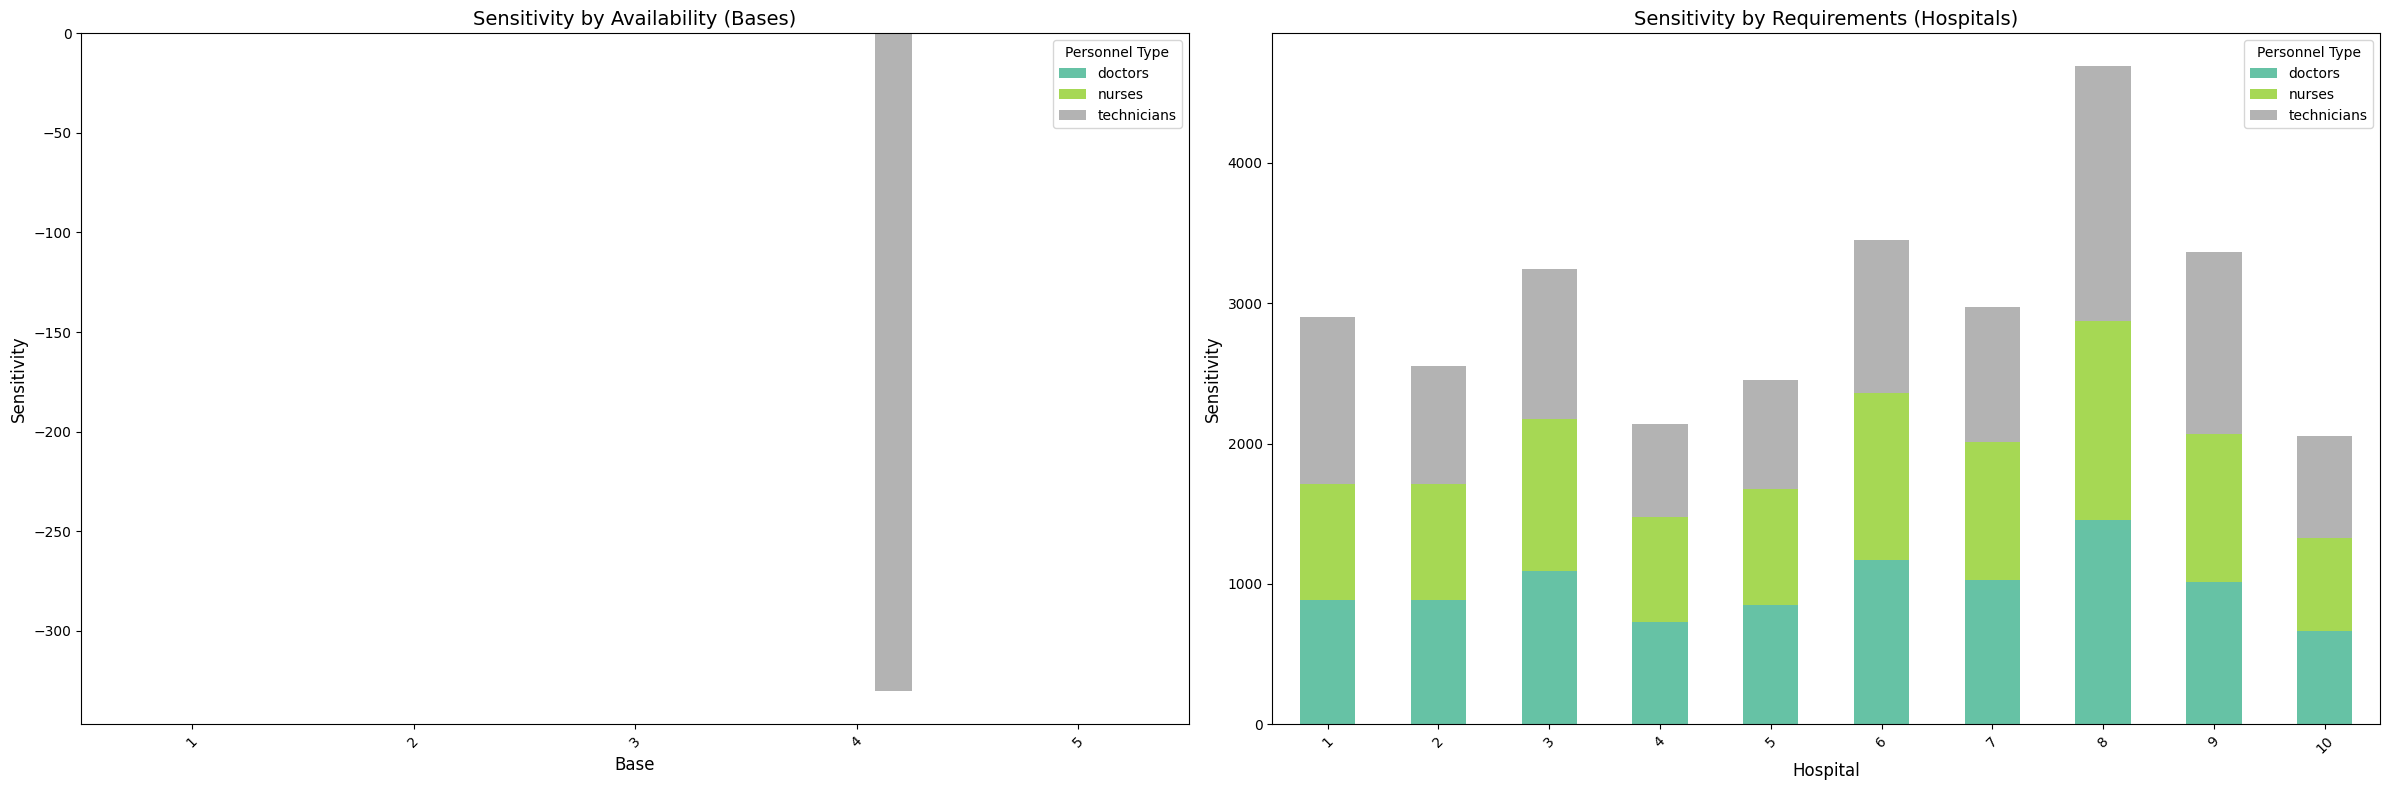

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

avail_table['Dual Value'].unstack().plot(
    kind='bar', ax=axes[0], colormap='Set2'
)
axes[0].set_title('Sensitivity by Availability (Bases)', fontsize=14)
axes[0].set_ylabel('Sensitivity', fontsize=12)
axes[0].set_xlabel('Base', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Personnel Type', fontsize=10)

req_table['Dual Value'].unstack().plot(
    kind='bar', ax=axes[1], stacked=True, colormap='Set2'
)
axes[1].set_title('Sensitivity by Requirements (Hospitals)', fontsize=14)
axes[1].set_ylabel('Sensitivity', fontsize=12)
axes[1].set_xlabel('Hospital', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Personnel Type', fontsize=10)


plt.tight_layout()
plt.show()


## **d) Dual problem**

In this section, we formulate the **dual problem** corresponding to the primal linear optimization model previously defined. The dual problem is constructed by **associating each constraint** in the primal with a **corresponding dual variable**, which represents the marginal value of relaxing that constraint.

The **goal** of the dual formulation is to **gain additional insights** into the problem structure, including the value of resources and the impact of meeting minimum requirements or maintaining proportionality constraints. The dual problem will also allow us to verify the Strong Duality Theorem, which states that the optimal value of the primal is equal to the optimal value of the dual when both problems have feasible and optimal solutions.

\
**DUAL VARIABLES**
- $\pi_{jt}:$ Dual variable associated with the minimum personnel requirements constraint for hospital  $j$  and personnel type $t$. Represents the marginal value of increasing the required personnel for hospital $j$ and type
$t$. It tells how much the objective function will increase if the minimum requirement $R_{jt}$ is increased by one unit.


- $\lambda_{it}:$ Dual variable associated with the availability constraint for base  $i$  and personnel type $t$. This variable reflects the marginal value of relaxing the personnel availability limit at base $i$. If base $i$ has a limited number of personnel of type $t$, the dual variable tells us how much the objective function would change if the available number of personnel at base $i$ for type $t$ were increased by one unit.


- $\mu_j:$Dual variable associated with the capacity constraint for hospital $j$. This dual variable represents the marginal value of increasing the maximum capacity $C_j$ at hospital $j$. It indicates how much the objective function would change if the total capacity at hospital $j$ were increased by one unit.


- $\nu_j:$ Dual variable associated with the constraint ensuring at least one person of each type is assigned to each hospital $j.$ This dual variable represents the marginal value of relaxing the condition that at least one person of each type must be assigned to each hospital. It tells us how much the objective function would change if we allowed hospitals to have fewer than one person of a given type.

\
**DUAL OBJECTIVE FUNCTION**

The dual objective is to maximize the weighted sum of the constraints, using the dual variables to represent the marginal worth of each constraint. The dual objective function is:

$$
\max W = \sum_{j \in J} \sum_{t \in T} \pi_{jt} \cdot R_{jt} - \sum_{i \in I} \sum_{t \in T} \lambda_{it} \cdot A_{it} - \sum_{j \in J} \mu_j \cdot C_j - \sum_{j \in J} \nu_j \cdot 1
$$

\
**CONSTRAINS**

The dual constraints are derived from the primal constraints. They ensure that the dual variables respect the relationships between the primal variables. The dual constraints are:

$$
\pi_{jt} - \lambda_{it} - \mu_j + \nu_j \leq c_{ijt} + d_{ij} \cdot \text{travel_cost_factor} + r_{ij} \cdot \text{risk_factor}, \quad \forall i \in I, \forall j \in J, \forall t \in T
$$

This constraint ensures that the dual variables provide an upper bound to the primal costs associated with assigning personnel, travel, and risk. Specifically:


- $C_{ijt} $: The direct personnel cost for assigning personnel of type
$t$ from base $i$ to hospital $j$

- $d_{ij}:$ Travel cost factor, the cost associated with transporting personnel from base $i$ to hospital $j$.

- $r_{ij}:$ Ris factor, the risk cost associated with transporting personnel.

\
The dual variables $\pi_{jt}$, $𝜆_{it}$, $𝜇_j$ and $v_j$ must together satisfy this constraint for each combination of $i$, $j$ and $t$. This constraint ensures that the dual variables provide an upper bound to the primal costs.

$$
\pi_{jt}, \lambda_{it}, \mu_j, \nu_j \geq 0, \quad \forall j \in J, \forall t \in T, \forall i \in I
$$


In [ ]:
def personnel_allocation_dual(I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor):
    """
    Formulates and solves the dual of the personnel allocation problem.

    Parameters:
    - I: List of bases.
    - J: List of hospitals.
    - personnel_types: Types of personnel.
    - costs: Personnel costs (3D matrix).
    - availability: Availability at bases.
    - requirements: Minimum personnel requirements per hospital.
    - capacities: Maximum capacity per hospital.
    - distances: Distances between bases and hospitals.
    - risks: Risks associated with transportation.
    - travel_cost_factor: Travel cost factor.
    - risk_factor: Risk factor.

    Returns:
    - results: Results of the dual model solution.
    - model: The solved dual model.
    - optimal_value: Optimal value of the dual objective function.
    """

    # Create dual model
    model_dual = pyo.ConcreteModel(name="Personnel Allocation Dual")

    # Define sets in the model
    model_dual.I = pyo.Set(initialize=I)
    model_dual.J = pyo.Set(initialize=J)
    model_dual.T = pyo.Set(initialize=personnel_types)


    personnel_type_map = {'doctors': 0, 'nurses': 1, 'technicians': 2}

    # Dual Variables (Multipliers)
    model_dual.pi = pyo.Var(model_dual.J, model_dual.T, domain=pyo.NonNegativeReals)
    model_dual.lambda_ = pyo.Var(model_dual.I, model_dual.T, domain=pyo.NonNegativeReals)
    model_dual.mu = pyo.Var(model_dual.J, domain=pyo.NonNegativeReals)
    model_dual.nu = pyo.Var(model_dual.J, domain=pyo.NonNegativeReals)

    # Objective function (dual)
    model_dual.obj = pyo.Objective(
        expr=sum(model_dual.pi[j, t] * requirements[j][t] for j in model_dual.J for t in model_dual.T) -
             sum(model_dual.lambda_[i, t] * availability[i][t] for i in model_dual.I for t in model_dual.T) -
             sum(model_dual.mu[j] * capacities[j] for j in model_dual.J) -
             sum(model_dual.nu[j] for j in model_dual.J),
        sense=pyo.maximize
    )

    # Dual Constraints
    def dual_constraint_rule(model, i, j, t):
        t_index = personnel_type_map[t]
        return (model_dual.pi[j, t] - model_dual.lambda_[i, t] - model_dual.mu[j] + model_dual.nu[j]) <= \
               (costs[i-1, j-1, t_index] + distances[(i, j)] * travel_cost_factor + risks[(i, j)] * risk_factor)
    model_dual.dual_constraints = pyo.Constraint(model_dual.I, model_dual.J, model_dual.T, rule=dual_constraint_rule)

    opt = pyo.SolverFactory('glpk')
    results_dual = opt.solve(model_dual, tee=True)

    if (results.solver.status != pyo.SolverStatus.ok) or (results.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise ValueError("Solver did not find an optimal solution.")

    optimal_value = pyo.value(model_dual.obj)
    duals = {
        "pi": { (j, t): model_dual.pi[j, t].value for j in model_dual.J for t in model_dual.T },
        "lambda": { (i, t): model_dual.lambda_[i, t].value for i in model_dual.I for t in model_dual.T },
        "mu": { j: model_dual.mu[j].value for j in model_dual.J },
        "nu": { j: model_dual.nu[j].value for j in model_dual.J }
    }

    return results_dual, model_dual, optimal_value, duals


### **Strong Duality Theorem**

The Strong Duality Theorem establishes a relationship between the primal and dual problems. It states that:


If the **primal problem** has an **optimal solution**, then the **dual problem** **also** has an **optimal solution**, and the **optimal values** of the primal and dual objective functions are **equal.**

In section **b)** we got that the optimal solution was **207,579.06€** from the primal problem, now we are going to check if the theorem holds.


In [ ]:
results_dual, model_dual, optimal_value, duals = personnel_allocation_dual(
    I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor
)



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpsf5artio.glpk.raw --wglp /tmp/tmpdnsvlake.glpk.glp --cpxlp
 /tmp/tmpoi5iag2y.pyomo.lp
Reading problem data from '/tmp/tmpoi5iag2y.pyomo.lp'...
150 rows, 65 columns, 600 non-zeros
1189 lines were read
Writing problem data to '/tmp/tmpdnsvlake.glpk.glp'...
1033 lines were written
GLPK Simplex Optimizer 5.0
150 rows, 65 columns, 600 non-zeros
Preprocessing...
150 rows, 65 columns, 600 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 150
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (30)
*    31: obj =   2.075790699e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (228653 bytes)
Writing basic solution to '/tmp/tmpsf5artio.glpk.raw'...
224 lines were written


In [ ]:
print(f"Optimal value of the dual problem: {optimal_value}")


Optimal value of the dual problem: 207579.06988344836


Since the **optimal values** of both the primal and dual problems are **equal**, this confirms that the **Strong Duality Theorem holds** in this case. The equality of the optimal objective function values indicates that both problems are feasible and that the optimal solutions of the primal and dual are tightly linked.

In [ ]:
def create_dual_tables(duals):
    pi_df = pd.DataFrame([
        {"Hospital": j, "Personnel Type": t, "Value": value}
        for (j, t), value in duals["pi"].items()
    ])
    lambda_df = pd.DataFrame([
        {"Base": i, "Personnel Type": t, "Value": value}
        for (i, t), value in duals["lambda"].items()
    ])
    mu_df = pd.DataFrame([
        {"Hospital": j, "Value": value}
        for j, value in duals["mu"].items()
    ])
    nu_df = pd.DataFrame([
        {"Hospital": j, "Value": value}
        for j, value in duals["nu"].items()
    ])
    return pi_df, lambda_df, mu_df, nu_df

pi_df, lambda_df, mu_df, nu_df = create_dual_tables(duals)

def print_pi():
    print(pi_df.to_string(index=False))

def print_lambda():
    print(lambda_df.to_string(index=False))

def print_mu():
    print(mu_df.to_string(index=False))

def print_nu():
    print(nu_df.to_string(index=False))


### **Interpretation of the Dual Variables**

**$𝜋$ (Requirements duals):**

These dual variables correspond to the minimum personnel requirements for each hospital and personnel type.
The values of $𝜋_{jt}$ indicate how much the objective function (total personnel allocation cost) would increase if the minimum personnel requirement for a specific type of personnel at a specific hospital were increased by one unit.

For Hospital 1, the dual value for doctors is 885.67. This means that if the minimum requirement for doctors at Hospital 1 were increased by one unit, the total cost would increase by 885.67 €.

A dual value of 0 indicates that the corresponding constraint is not binding, meaning it does not affect the total cost in the current optimal solution. In this case, relaxing or tightening this constraint would have no impact on the optimal outcome.


In [ ]:
print_pi()

 Hospital Personnel Type       Value
        1        doctors  885.676830
        1         nurses  829.676830
        1    technicians 1187.199345
        2        doctors  886.398859
        2         nurses  825.398859
        2    technicians  838.398859
        3        doctors 1094.686456
        3         nurses 1080.686456
        3    technicians 1070.686456
        4        doctors  726.475038
        4         nurses  749.475038
        4    technicians  661.475038
        5        doctors  850.660662
        5         nurses  822.660662
        5    technicians  778.660662
        6        doctors 1168.969635
        6         nurses 1194.969635
        6    technicians 1088.969635
        7        doctors 1031.141528
        7         nurses  978.141528
        7    technicians  967.141528
        8        doctors 1453.634064
        8         nurses 1416.634064
        8    technicians 1818.156579
        9        doctors 1010.820272
        9         nurses 1056.820272
 


**𝜆 (Availability duals):**

These dual variables correspond to the personnel availability constraints at each base for each personnel type.
The values of $𝜆_{it}$ represent the marginal value of relaxing the personnel availability limit at a particular base and for a particular type of personnel.

In the case of bases 1 through 3, there are no dual values (all zero), which indicates that relaxing the personnel availability limits at these bases doesn't affect the objective function. However, for base 4, for example, the dual value for technicians is 330.52, meaning that relaxing the technician availability constraint at base 4 would decrease the total cost by 330.52.

In [ ]:
print_lambda()

 Base Personnel Type      Value
    1        doctors   0.000000
    1         nurses   0.000000
    1    technicians   0.000000
    2        doctors   0.000000
    2         nurses   0.000000
    2    technicians   0.000000
    3        doctors   0.000000
    3         nurses   0.000000
    3    technicians   0.000000
    4        doctors   0.000000
    4         nurses   0.000000
    4    technicians 330.522515
    5        doctors   0.000000
    5         nurses   0.000000
    5    technicians   0.000000



**$𝜇$ (Capacity duals):**

These dual variables correspond to the capacity constraints for each hospital.
The values of $𝜇_j$ show the marginal value of increasing the capacity at each hospital.

Here, all the dual values for the capacity constraints are zero, indicating that the hospital capacities are not "binding" constraints in the optimal solution. In other words, none of the hospitals are at full capacity in the optimal allocation, so increasing their capacity wouldn't affect the overall cost.

In [ ]:
print_mu()

 Hospital  Value
        1    0.0
        2    0.0
        3    0.0
        4    0.0
        5    0.0
        6    0.0
        7    0.0
        8    0.0
        9    0.0
       10    0.0


**$\nu$ (Minimum personnel duals):**

These dual variables are associated with the constraint ensuring at least one person of each type is assigned to each hospital.

In this case, all dual values are zero, meaning that the "at least one person" constraint is not active in the optimal solution. This suggests that for all hospitals, the optimal solution already assigns more than one person of each type, so there's no need to relax this constraint.

In [ ]:
print_nu()

 Hospital  Value
        1    0.0
        2    0.0
        3    0.0
        4    0.0
        5    0.0
        6    0.0
        7    0.0
        8    0.0
        9    0.0
       10    0.0




\
**Key Takeaways:**

- **Binding vs. Non-binding Constraints:**

  The availability constraints for base 4 and the minimum personnel requirements are active (non-zero dual values), meaning that relaxing them would affect the total cost.The capacity constraints and the "at least one person" constraint are inactive (zero dual values), meaning they do not influence the optimal allocation in this case.

- **No Over-capacity Utilization:**

  Since the capacity duals are zero for all hospitals, this indicates that all hospitals are not reaching their maximum capacity in the optimal solution. Increasing the capacities of the hospitals would not change the optimal allocation or total cost.

- **Potential Sensitivity:**

  The non-zero dual values for personnel requirements and availability at base 4 suggest that sensitivity analysis could be useful for exploring how changes to these parameters (like increasing personnel requirements or base availability) would affect the overall system. For example, increasing the required number of technicians at hospital 4 by one unit would lead to a reduction in cost of 71.32, according to the dual values.

  \
  We can plot the results to have a visual explanation.

<ipython-input-27-bb92933ded24>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = get_cmap('Set2', len(personnel_types)).colors


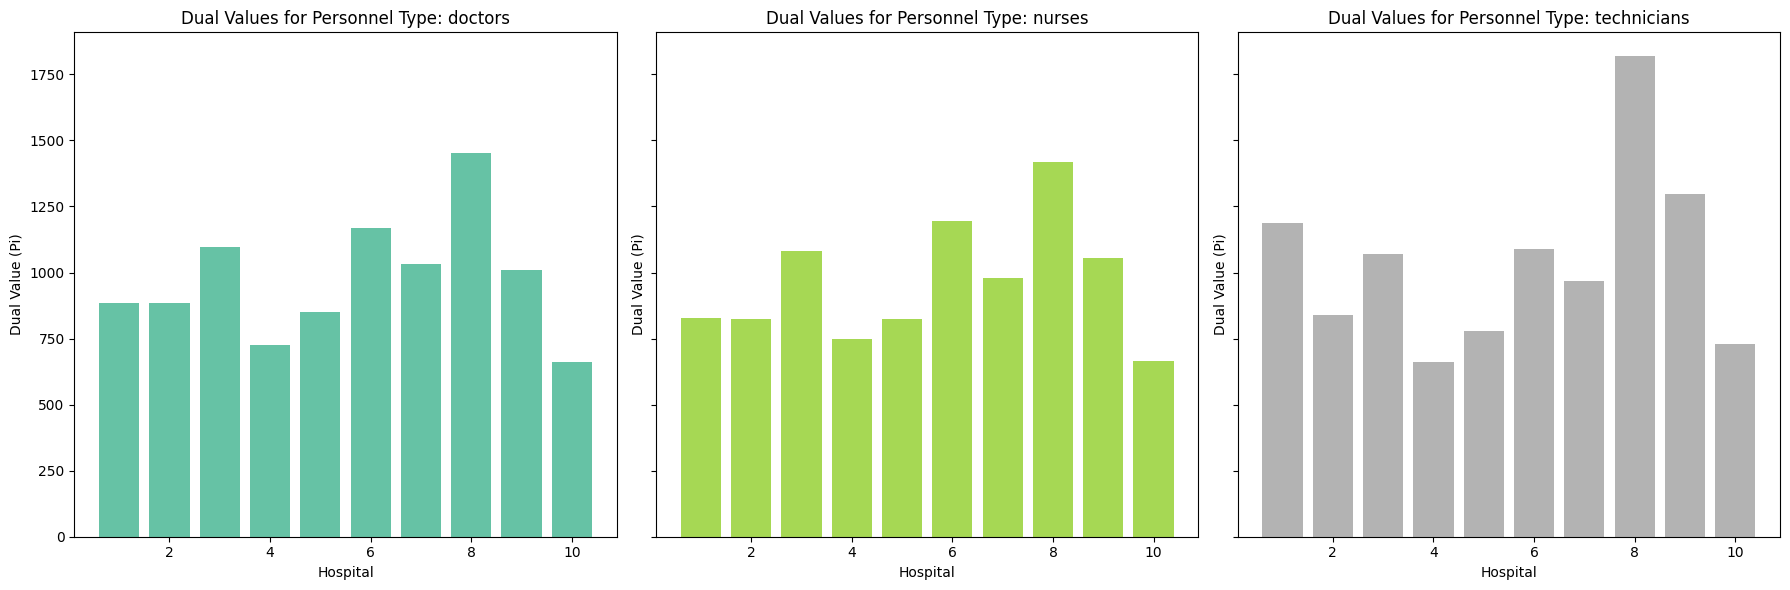

In [ ]:
pi_values = duals['pi']

hospitals = list(range(1, 11))
personnel_types = ['doctors', 'nurses', 'technicians']

set2_colors = get_cmap('Set2', len(personnel_types)).colors

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for idx, t in enumerate(personnel_types):
    values = [pi_values[(j, t)] for j in hospitals]
    axes[idx].bar(hospitals, values, color=set2_colors[idx])
    axes[idx].set_title(f'Dual Values for Personnel Type: {t}')
    axes[idx].set_xlabel('Hospital')
    axes[idx].set_ylabel('Dual Value (Pi)')

plt.tight_layout()
plt.show()


The three graphs visualize the dual values $\pi$ for different personnel types: doctors, nurses, and technicians, distributed across ten hospitals.

The x-axis in all graphs represents the hospital indices from 1 to 10, while the y-axis shows the dual value, which reflects the marginal cost of meeting personnel requirements for a given hospital and personnel type. The heights of the bars indicate how critical it is to satisfy the personnel requirements in each hospital.

In the first graph, corresponding to doctors, the dual values vary across hospitals. Some hospitals, like hospital 8, show higher values, indicating that the personnel requirement for doctors there is more critical compared to other hospitals.

The second graph, for nurses, has a similar pattern but with variations in the criticality. Hospitals with higher values, such as hospital 8, indicate constrained resources for nurses.

The third graph, for technicians, shows distinct dual values across hospitals. Hospital 8, in particular, has a significant peak, indicating a highly constrained requirement for technicians. Overall, these graphs help identify which hospitals face tighter constraints on personnel requirements for each type, guiding resource allocation and operational planning.

## **e) Binary variables**

The Ebola outbreak in Africa was growing fast and required a rapid and efficient response, particularly in remote and hard-to-reach areas. The humanitarian organization faced several logistical and operational challenges.

To address these challenges, the allocation model was enhanced with binary variables to reflect real-world operational constraints and priorities:

- **Route prioritization:** Due to transportation bottlenecks, not all routes from bases to hospitals could be activated. Limiting the number of active routes ensured that resources were focused on the most critical paths.

- **Base activation:** Activating every resource base was impractical due to logistical and operational constraints. Limiting the number of active bases enabled better resource management and reduced overhead costs.

\
**BINARY VARIABLES**

- **Route activation ($y_{ij}$):** Indicates whether a route between a base and a hospital is operational, allowing personnel to be assigned.

$$
y_{ij} =
\begin{cases}
1 & \text{if the route between base } i \text{ and hospital } j \text{ is active,} \\
0 & \text{otherwise.}
\end{cases}
$$

- **Base activation ($z_i$):** Indicates whether a base is operational, controlling whether it can support active routes to hospitals.

$$
z_i =
\begin{cases}
1 & \text{if base } i \text{ is active,} \\
0 & \text{otherwise.}
\end{cases}
$$

**CONSTRAINS**
1. Personnel assignment depends on route activation:
$$
x_{ijt} \leq M \cdot y_{ij}, \quad \forall i \in B, \forall j \in H, \forall t \in T
$$

2. Route activation depends on personnel assignment:
$$
y_{ij} \leq \sum_{t \in T} x_{ijt}, \quad \forall i \in B, \forall j \in H
$$

3. Limit on the total number of active routes:
$$
\sum_{i \in B} \sum_{j \in H} y_{ij} \leq K
$$

4. Route activation depends on base activation:
$$
y_{ij} \leq z_i, \quad \forall i \in B, \forall j \in H
$$

5. Limit on the total number of active bases:
$$
\sum_{i \in B} z_i \leq L
$$



In [ ]:
def personnel_allocation_with_base_limit(
    I, J, personnel_types, costs, availability, requirements, capacities, distances, risks,
    travel_cost_factor, risk_factor, M=1000, K=10, L=3
):
    """
    Function to solve the personnel allocation problem with binary variables for routes and bases,
    limiting the number of active routes and bases.

    Parameters:
    - I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor: As defined previously.
    - M: A large constant for logical constraints.
    - K: Maximum number of routes that can be activated.
    - L: Maximum number of bases that can be active.

    Returns:
    - Results of the model solution, optimal value, and assignments.
    """
    # Create model
    model = pyo.ConcreteModel(name="Personnel Allocation with Base and Route Limits")

    # Sets
    model.I = pyo.Set(initialize=I)
    model.J = pyo.Set(initialize=J)
    model.T = pyo.Set(initialize=personnel_types)

    # Variables
    model.x = pyo.Var(model.I, model.J, model.T, domain=pyo.NonNegativeReals)  # Personnel assigned
    model.y = pyo.Var(model.I, model.J, domain=pyo.Binary)  # Route active or not
    model.z = pyo.Var(model.I, domain=pyo.Binary)  # Base active or not

    # Objective function
    def obj_expression(model):
        return sum(
            costs[i-1, j-1, t_idx] * model.x[i, j, t] +
            distances[(i, j)] * travel_cost_factor * model.x[i, j, t] +
            risks[(i, j)] * risk_factor * model.x[i, j, t]
            for i in model.I for j in model.J for t_idx, t in enumerate(model.T)
        )
    model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.minimize)

    # Constraints

    # 1. Minimum personnel requirements
    def req_constraint_rule(model, j, t):
        return sum(model.x[i, j, t] for i in model.I) >= requirements[j][t]
    model.req_Constraint = pyo.Constraint(model.J, model.T, rule=req_constraint_rule)

    # 2. Availability at bases
    def avail_constraint_rule(model, i, t):
        return sum(model.x[i, j, t] for j in model.J) <= availability[i][t]
    model.avail_Constraint = pyo.Constraint(model.I, model.T, rule=avail_constraint_rule)

    # 3. Maximum capacity per hospital
    def cap_constraint_rule(model, j):
        return sum(model.x[i, j, t] for i in model.I for t in model.T) <= capacities[j]
    model.cap_Constraint = pyo.Constraint(model.J, rule=cap_constraint_rule)

    # 4. Logical constraint: Activate y_{ij} if x_{ijt} > 0
    def logical_activation_rule(model, i, j, t):
        return model.x[i, j, t] <= M * model.y[i, j]
    model.logical_activation = pyo.Constraint(model.I, model.J, model.T, rule=logical_activation_rule)

    # 5. Logical constraint: y_{ij} must be 1 if personnel are assigned
    def activation_threshold_rule(model, i, j):
        return model.y[i, j] <= sum(model.x[i, j, t] for t in model.T)
    model.activation_threshold = pyo.Constraint(model.I, model.J, rule=activation_threshold_rule)

    # 6. Limit on the number of routes activated
    def limit_routes_rule(model):
        return sum(model.y[i, j] for i in model.I for j in model.J) <= K
    model.limit_routes = pyo.Constraint(rule=limit_routes_rule)

    # 7. Logical constraint: y_{ij} depends on z_i (base activation)
    def base_activation_rule(model, i, j):
        return model.y[i, j] <= model.z[i]
    model.base_activation = pyo.Constraint(model.I, model.J, rule=base_activation_rule)

    # 8. Limit on the number of active bases
    def limit_bases_rule(model):
        return sum(model.z[i] for i in model.I) <= L
    model.limit_bases = pyo.Constraint(rule=limit_bases_rule)

    model.dual = Suffix(direction=Suffix.IMPORT)
    # Solve model
    opt = SolverFactory('glpk')
    results = opt.solve(model, tee=True)

    # Ensure the model is solved
    if (results.solver.status != pyo.SolverStatus.ok) or (results.solver.termination_condition != pyo.TerminationCondition.optimal):
        raise ValueError("Solver did not find an optimal solution.")

    # Extract results
    optimal_value = pyo.value(model.OBJ)
    assignments = {
        (i, j, t): model.x[i, j, t].value
        for i in model.I for j in model.J for t in model.T if model.x[i, j, t].value > 0
    }
    binary_decisions_routes = {
        (i, j): model.y[i, j].value
        for i in model.I for j in model.J
    }
    binary_decisions_bases = {
        i: model.z[i].value for i in model.I
    }

    return results, optimal_value, assignments, binary_decisions_routes, binary_decisions_bases, model


### **Numerical Analysis**

The same data as in part a) is used.

In [ ]:
np.random.seed(2)
I = range(1, 6)  # 5 bases
J = range(1, 11)  # 10 hospitals
personnel_types = ['doctors', 'nurses', 'technicians']

# Parameters

# Costs of personnel
costs = np.random.randint(50, 200, size=(len(I), len(J), len(personnel_types)))

# Availability in bases
availability = {
    1: {'doctors': 40, 'nurses': 50, 'technicians': 40},
    2: {'doctors': 30, 'nurses': 40, 'technicians': 30},
    3: {'doctors': 30, 'nurses': 40, 'technicians': 30},
    4: {'doctors': 20, 'nurses': 30, 'technicians': 20},
    5: {'doctors': 20, 'nurses': 30, 'technicians': 20}
}

# Minimum requirements in hospitals
requirements = {
    1: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    2: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    3: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    4: {'doctors': 5, 'nurses': 8, 'technicians': 6},
    5: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    6: {'doctors': 6, 'nurses': 10, 'technicians': 8},
    7: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    8: {'doctors': 5, 'nurses': 8, 'technicians': 6},
    9: {'doctors': 5, 'nurses': 10, 'technicians': 8},
    10: {'doctors': 4, 'nurses': 6, 'technicians': 4}
}

# Maximum capacity per hospital
capacities = {
    1: 50, 2: 50, 3: 50, 4: 40, 5: 50,
    6: 50, 7: 50, 8: 50, 9: 50, 10: 40
}


# Distances between bases and hospitals
distances = {
    (i, j): np.random.randint(1000, 5000) for i in I for j in J
}

# Risk associated with transport
risks = {
    (i, j): np.random.uniform(0.1, 1.0) for i in I for j in J
}

# Travel factor cost
travel_cost_factor = 0.5

# Risk Factor
risk_factor = 50
L = 3  # Maximum number of bases that can be active.
K = 10 # Maximum number of routes that can be activated.



In [ ]:
results_bi, optimal_value_bi, assignments_bi, binary_decisions_routes, binary_decisions_bases, model_bi = personnel_allocation_with_base_limit(
    I=I,
    J=J,
    personnel_types=personnel_types,
    costs=costs,
    availability=availability,
    requirements=requirements,
    capacities=capacities,
    distances=distances,
    risks=risks,
    travel_cost_factor=travel_cost_factor,
    risk_factor=risk_factor,
    M=1000,
    K=K,
    L=L
)



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpiichoyqg.glpk.raw --wglp /tmp/tmpfozd0uw_.glpk.glp --cpxlp
 /tmp/tmpyulpbjok.pyomo.lp
Reading problem data from '/tmp/tmpyulpbjok.pyomo.lp'...
/tmp/tmpyulpbjok.pyomo.lp:2391: warning: lower bound of variable 'x208' redefined
/tmp/tmpyulpbjok.pyomo.lp:2391: warning: upper bound of variable 'x208' redefined
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
2446 lines were read
Writing problem data to '/tmp/tmpfozd0uw_.glpk.glp'...
2227 lines were written
GLPK Integer Optimizer 5.0
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
Preprocessing...
150 constraint coefficient(s) were reduced
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  5.000e+01  ratio =  5.000e+01
GM: min|aij| =  3.761e-01  max|aij| =  2.659e+00  ratio =  7.071e+00
EQ: min|aij| 

The solver found the optimal integer solution at iteration 904, while the continuous relaxation of the problem was solved at iteration 78. This demonstrates the additional complexity introduced by the integer constraints, as the solver had to explore and prune the solution tree extensively to ensure that the solution satisfies the integrality requirements, significantly increasing the number of iterations needed to reach optimality.

#### **Optimal value**

The optimal value has increased from **€207,579.06** to **€235,444.39** due to the additional integer constraints and restrictions. This represents a percentage increase of approximately **13.43%**, highlighting the cost impact of enforcing these stricter conditions on the solution.

In [ ]:
print("Optimal Value:", optimal_value_bi)


Optimal Value: 235444.3904606452


We can see how the assigments have been done. As the maximum number of bases was 3, only bases $2$, $3$ and $4$ are active.

In [ ]:
print("Binary decisions for bases:")
for i, value in binary_decisions_bases.items():
    print(f"Base {i}: {'Activated' if value > 0.5 else 'Not activated'}")


Binary decisions for bases:
Base 1: Not activated
Base 2: Activated
Base 3: Activated
Base 4: Activated
Base 5: Not activated


In [ ]:
print("Assignments:")
for (i, j, t), value in assignments_bi.items():
    print(f"Base {i} -> Hospital {j} ({t}): {value}")


Assignments:
Base 2 -> Hospital 3 (doctors): 5.0
Base 2 -> Hospital 3 (nurses): 10.0
Base 2 -> Hospital 3 (technicians): 8.0
Base 2 -> Hospital 5 (doctors): 5.0
Base 2 -> Hospital 5 (nurses): 10.0
Base 2 -> Hospital 5 (technicians): 8.0
Base 2 -> Hospital 7 (doctors): 5.0
Base 2 -> Hospital 7 (nurses): 10.0
Base 2 -> Hospital 7 (technicians): 8.0
Base 2 -> Hospital 8 (doctors): 5.0
Base 2 -> Hospital 8 (nurses): 8.0
Base 2 -> Hospital 8 (technicians): 6.0
Base 3 -> Hospital 2 (doctors): 5.0
Base 3 -> Hospital 2 (nurses): 10.0
Base 3 -> Hospital 2 (technicians): 8.0
Base 3 -> Hospital 4 (doctors): 5.0
Base 3 -> Hospital 4 (nurses): 8.0
Base 3 -> Hospital 4 (technicians): 6.0
Base 3 -> Hospital 6 (doctors): 6.0
Base 3 -> Hospital 6 (nurses): 10.0
Base 3 -> Hospital 6 (technicians): 8.0
Base 4 -> Hospital 1 (doctors): 5.0
Base 4 -> Hospital 1 (nurses): 10.0
Base 4 -> Hospital 1 (technicians): 8.0
Base 4 -> Hospital 9 (doctors): 5.0
Base 4 -> Hospital 9 (nurses): 10.0
Base 4 -> Hospital 9 

We can also see which routes are active:

In [ ]:
print("\nBinary decisions for routes:")
for (i, j), value in binary_decisions_routes.items():
    print(f"Route Base {i} -> Hospital {j}: {'Activated' if value > 0.5 else 'Not activated'}")


Binary decisions for routes:
Route Base 1 -> Hospital 1: Not activated
Route Base 1 -> Hospital 2: Not activated
Route Base 1 -> Hospital 3: Not activated
Route Base 1 -> Hospital 4: Not activated
Route Base 1 -> Hospital 5: Not activated
Route Base 1 -> Hospital 6: Not activated
Route Base 1 -> Hospital 7: Not activated
Route Base 1 -> Hospital 8: Not activated
Route Base 1 -> Hospital 9: Not activated
Route Base 1 -> Hospital 10: Not activated
Route Base 2 -> Hospital 1: Not activated
Route Base 2 -> Hospital 2: Not activated
Route Base 2 -> Hospital 3: Activated
Route Base 2 -> Hospital 4: Not activated
Route Base 2 -> Hospital 5: Activated
Route Base 2 -> Hospital 6: Not activated
Route Base 2 -> Hospital 7: Activated
Route Base 2 -> Hospital 8: Activated
Route Base 2 -> Hospital 9: Not activated
Route Base 2 -> Hospital 10: Not activated
Route Base 3 -> Hospital 1: Not activated
Route Base 3 -> Hospital 2: Activated
Route Base 3 -> Hospital 3: Not activated
Route Base 3 -> Hospit

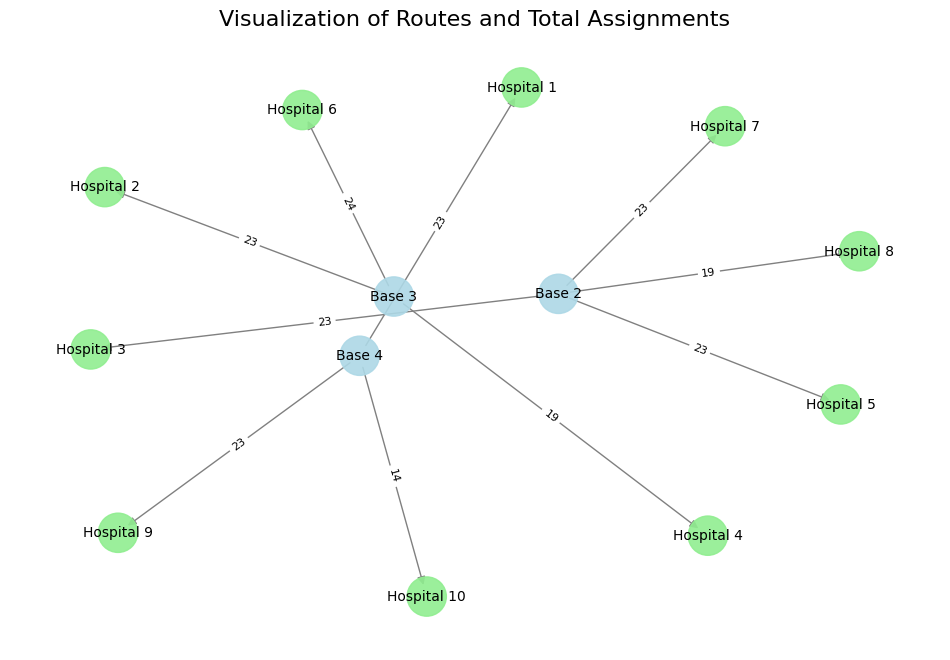

In [ ]:
assignments = [
    (2, 3, 'doctors', 5.0),
    (2, 3, 'nurses', 10.0),
    (2, 3, 'technicians', 8.0),
    (2, 5, 'doctors', 5.0),
    (2, 5, 'nurses', 10.0),
    (2, 5, 'technicians', 8.0),
    (2, 7, 'doctors', 5.0),
    (2, 7, 'nurses', 10.0),
    (2, 7, 'technicians', 8.0),
    (2, 8, 'doctors', 5.0),
    (2, 8, 'nurses', 8.0),
    (2, 8, 'technicians', 6.0),
    (3, 2, 'doctors', 5.0),
    (3, 2, 'nurses', 10.0),
    (3, 2, 'technicians', 8.0),
    (3, 4, 'doctors', 5.0),
    (3, 4, 'nurses', 8.0),
    (3, 4, 'technicians', 6.0),
    (3, 6, 'doctors', 6.0),
    (3, 6, 'nurses', 10.0),
    (3, 6, 'technicians', 8.0),
    (4, 1, 'doctors', 5.0),
    (4, 1, 'nurses', 10.0),
    (4, 1, 'technicians', 8.0),
    (4, 9, 'doctors', 5.0),
    (4, 9, 'nurses', 10.0),
    (4, 9, 'technicians', 8.0),
    (4, 10, 'doctors', 4.0),
    (4, 10, 'nurses', 6.0),
    (4, 10, 'technicians', 4.0)
]

total_assignments = defaultdict(float)
for base, hospital, _, amount in assignments:
    total_assignments[(base, hospital)] += amount

G = nx.DiGraph()

for (base, hospital), total in total_assignments.items():
    G.add_node(f"Base {base}", type="Base")
    G.add_node(f"Hospital {hospital}", type="Hospital")
    if total > 0:
        G.add_edge(f"Base {base}", f"Hospital {hospital}", weight=total)

node_colors = [
    'lightblue' if data['type'] == "Base" else 'lightgreen' for _, data in G.nodes(data=True)
]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowstyle='-|>', arrowsize=12)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

edge_labels = {(u, v): f"{data['weight']:.0f}" for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Visualization of Routes and Total Assignments", fontsize=16)
plt.axis('off')
plt.show()


We can see how the graph has change compared to the model with out binary variables.



## **f) Different number of variables and constrains**

In this section, the integer problem defined in part (e) will be tested with multiple instances of different sizes. The computational performance of the model will be analyzed by measuring the execution time required to solve each instance.




### **Bases**

In the first place the variations in size will be achieved by modifying the number of available bases in the model, ranging from 3 to 30. Additionally, the parameters that were previously fixed (such as costs, personnel availability, requirements, capacities, distances, and risks) will now be generated randomly for each instance.

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpz_oxsk0s.glpk.raw --wglp /tmp/tmpl1afy0x7.glpk.glp --cpxlp
 /tmp/tmpsr8vt9xb.pyomo.lp
Reading problem data from '/tmp/tmpsr8vt9xb.pyomo.lp'...
/tmp/tmpsr8vt9xb.pyomo.lp:1489: warning: lower bound of variable 'x142' redefined
/tmp/tmpsr8vt9xb.pyomo.lp:1489: warning: upper bound of variable 'x142' redefined
201 rows, 123 columns, 663 non-zeros
33 integer variables, all of which are binary
1522 lines were read
Writing problem data to '/tmp/tmpl1afy0x7.glpk.glp'...
1371 lines were written
GLPK Integer Optimizer 5.0
201 rows, 123 columns, 663 non-zeros
33 integer variables, all of which are binary
Preprocessing...
90 constraint coefficient(s) were reduced
200 rows, 123 columns, 660 non-zeros
33 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.700e+01  ratio =  4.700e+01
GM: min|aij| =  3.819e-01  max|aij| =  2.618e+00  ratio =  6.856e+00
EQ: min|aij| =  1

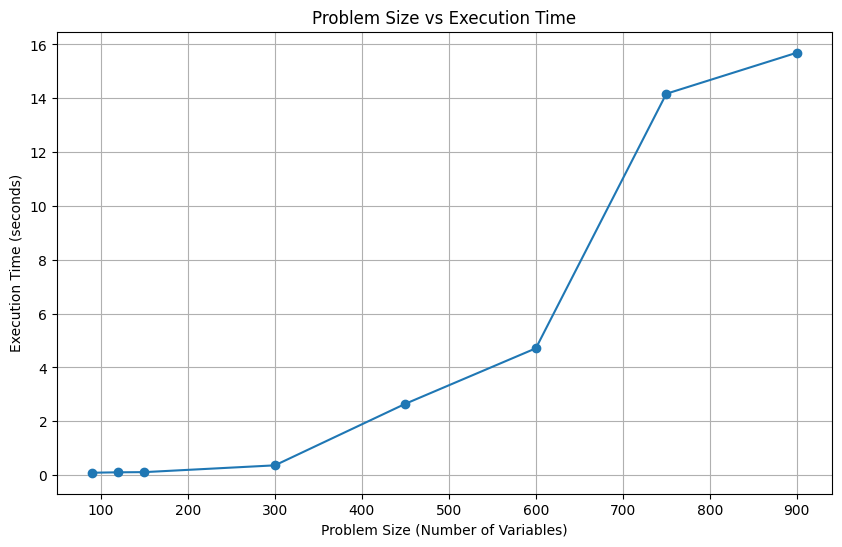

In [ ]:
def size_model(I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor, M, K, L):

    try:
        start_time = time.time()
        personnel_allocation_with_base_limit(
            I=I, J=J, personnel_types=personnel_types,
            costs=costs, availability=availability,
            requirements=requirements, capacities=capacities,
            distances=distances, risks=risks,
            travel_cost_factor=travel_cost_factor, risk_factor=risk_factor,
            M=M, K=K, L=L
        )
        end_time = time.time()

        return end_time - start_time
    except Exception as e:

        print(f"Error: {e}")
        return None

np.random.seed(42)
def generate_parameters(I_size, J_size, personnel_types):

    np.random.seed(42)

    costs = np.random.randint(50, 200, size=(I_size, J_size, len(personnel_types)))

    availability = {
        i: {t: np.random.randint(20, 50) for t in personnel_types} for i in range(1, I_size + 1)
    }

    requirements = {
        j: {t: np.random.randint(3, 10) for t in personnel_types} for j in range(1, J_size + 1)
    }

    capacities = {j: np.random.randint(30, 60) for j in range(1, J_size + 1)}

    distances = {
        (i, j): np.random.randint(1000, 5000) for i in range(1, I_size + 1) for j in range(1, J_size + 1)
    }

    risks = {
        (i, j): np.random.uniform(0.1, 1.0) for i in range(1, I_size + 1) for j in range(1, J_size + 1)
    }

    return costs, availability, requirements, capacities, distances, risks


# CHANGE PARAMETERS
instances = [(3, 10), (4, 10), (5, 10), (10, 10), (15, 10), (20, 10), (25, 10), (30, 10)]
personnel_types = ['doctors', 'nurses', 'technicians']
travel_cost_factor = 0.5
risk_factor = 50
M = 1000
K = 10
L = 3

results = []

for I_size, J_size in instances:
    costs, availability, requirements, capacities, distances, risks = generate_parameters(I_size, J_size, personnel_types)

    computation_time = size_model(
        range(1, I_size + 1), range(1, J_size + 1), personnel_types,
        costs, availability, requirements, capacities, distances, risks,
        travel_cost_factor, risk_factor, M, K, L
    )

    problem_size = I_size * J_size * len(personnel_types)
    results.append((problem_size, computation_time))

results_df = pd.DataFrame(results, columns=["Problem Size (Variables)", "Execution Time (s)"])

valid_results = results_df.dropna()
plt.figure(figsize=(10, 6))
plt.plot(valid_results["Problem Size (Variables)"], valid_results["Execution Time (s)"], marker='o')
plt.title('Problem Size vs Execution Time')
plt.xlabel('Problem Size (Number of Variables)')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# aprox 40 seg to execute


In [ ]:
results_df.round(2)

,Problem Size (Variables),Execution Time (s)
0,90,0.09
1,120,0.10
2,150,0.11
3,300,0.36
4,450,2.65
5,600,4.71
6,750,14.17
7,900,15.69


As expected, the computational time increases as the problem size grows. This result aligns with the nature of mixed-integer programming problems, which are known to exhibit exponential or superlinear growth in computational complexity as the number of variables and constraints increases.

- **Small Problem Sizes (90–300 Variables):** For smaller instances, the execution time remains relatively low and manageable. For example, for problem sizes of 90 and 120 variables, the computational time is under 0.2 seconds.

- **Medium Problem Sizes (450–600 Variables):** In this range, the execution time begins to rise significantly. At 450 variables, the computational time jumps to approximately 3 seconds, and for 600 variables, it reaches over 4.5 seconds. This reflects the increasing computational burden associated with managing a larger number of bases and hospital assignments while respecting the constraints.

- **Large Problem Sizes (750–900 Variables):** For the largest instances, the computational time grows sharply, reaching over 14 seconds for 750 variables and approximately 15 seconds for 900 variables.

### **Hospitals**

In an attempt to evaluate the model's scalability, the number of hospitals $J$ was incrementally increased to observe how the computational time would scale with this parameter. However, during the experiments, the model with binary variables failed to execute successfully even when the number of hospitals was increased by only one unit.

This can be due to:

- **Unequal Impact on the Number of Variables:**
When increasing $J$ (number of hospitals), the growth in variables $x_{ijt}$, $y_{ij}$ and associated constraints is more significant compared to increasing $I$(number of bases).

  - Assignment Variables $x_{ijt}$:
    - If $I$ increases, variables grow proportionally to $|J| \cdot |T|$.
    - If $J$ increases, variables grow proportionally to $|I| \cdot |T|$.
    - If $|J|$ is already larger than $|I|$, increasing $J$ will have a much greater impact.

  - Associated Constraints: Capacity and minimum requirements constraints depend directly on $J$.
    - Each hospital $j$ adds one capacity constraint.
    - Each hospital $j$ adds $|T|$ constraints for minimum personnel requirements.

- **Binary Route Constraints ($y_{ij}$):**

  Binary variables $y_{ij}$ (route activation) grow as $|I| \cdot |J|$.This means that every increase in $J$ has a multiplicative effect, especially in integer programming problems.


Thus, $J$ has a larger impact on the model size than $I$.

\
To explore the scalability of the problem, we will test the model without binary variables. By removing the binary constraints, the model is expected to have fewer restrictions, potentially allowing for an increase in problem size.

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp_apjhm91.glpk.raw --wglp /tmp/tmpd_hy285c.glpk.glp --cpxlp
 /tmp/tmpzisx25jt.pyomo.lp
Reading problem data from '/tmp/tmpzisx25jt.pyomo.lp'...
55 rows, 150 columns, 600 non-zeros
1074 lines were read
Writing problem data to '/tmp/tmpd_hy285c.glpk.glp'...
1013 lines were written
GLPK Simplex Optimizer 5.0
55 rows, 150 columns, 600 non-zeros
Preprocessing...
55 rows, 150 columns, 600 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55
      0: obj =   0.000000000e+00 inf =   1.010e+02 (20)
     21: obj =   1.350188510e+05 inf =   0.000e+00 (0)
*    30: obj =   9.718798208e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (194833 bytes)
Writing basic solution to '/tmp/tmp_apjhm91.glpk.raw'...
214 lines were written
GLPSOL--

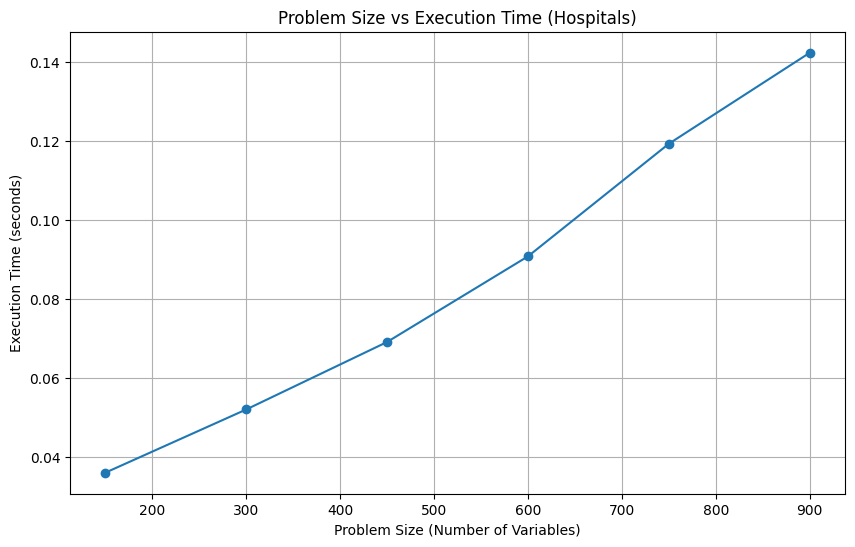

In [ ]:
def size_model_hospitals(I, J, personnel_types, costs, availability, requirements, capacities, distances, risks, travel_cost_factor, risk_factor):

    try:
        start_time = time.time()
        personnel_allocation(
            I=I, J=J, personnel_types=personnel_types,
            costs=costs, availability=availability,
            requirements=requirements, capacities=capacities,
            distances=distances, risks=risks,
            travel_cost_factor=travel_cost_factor, risk_factor=risk_factor
        )
        end_time = time.time()

        return end_time - start_time
    except Exception as e:
        print(f"Error: {e}")
        return None

instances_hospitals = [(10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (10, 30), (10, 50), (10, 100)]
personnel_types = ['doctors', 'nurses', 'technicians']
travel_cost_factor = 0.5
risk_factor = 50

results_hospitals = []

for I_size, J_size in instances_hospitals:
    costs, availability, requirements, capacities, distances, risks = generate_parameters(I_size, J_size, personnel_types)

    computation_time = size_model_hospitals(
        range(1, I_size + 1), range(1, J_size + 1), personnel_types,
        costs, availability, requirements, capacities, distances, risks,
        travel_cost_factor, risk_factor
    )

    problem_size = I_size * J_size * len(personnel_types)
    results_hospitals.append((problem_size, computation_time))

results_hospitals_df = pd.DataFrame(results_hospitals, columns=["Problem Size (Variables)", "Execution Time (s)"])


valid_results_hospitals = results_hospitals_df.dropna()
plt.figure(figsize=(10, 6))
plt.plot(valid_results_hospitals["Problem Size (Variables)"], valid_results_hospitals["Execution Time (s)"], marker='o')
plt.title('Problem Size vs Execution Time (Hospitals)')
plt.xlabel('Problem Size (Number of Variables)')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()


In [ ]:
results_hospitals_df.round(2)

,Problem Size (Variables),Execution Time (s)
0,150,0.04
1,300,0.04
2,450,0.07
3,600,0.08
4,750,0.09
5,900,0.11
6,1500,NaN
7,3000,NaN


As we can see the execution time grows steadily as the problem size increases, indicating a nearly linear increase up to a size of approximately 900 variables.However, for the last two instances (with problem sizes of 1500 and 3000 variables), the solver was unable to find an optimal solution. This result suggests that, despite reducing complexity by removing binary variables, there is still a limit to the scalability of the model.

## **g) Different values of the parameter**

In this section, we aim to analyze the **sensitivity** of the model to **changes** in parameters related to **risk** by solving several instances of the integer problem defined in Part e). Specifically, we modify the risk factor parameter to assess how it impacts the optimal value of the objective function, the personnel assignments, and the number of active routes.

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpey6xork0.glpk.raw --wglp /tmp/tmpanpk_8xy.glpk.glp --cpxlp
 /tmp/tmpb1qsks0j.pyomo.lp
Reading problem data from '/tmp/tmpb1qsks0j.pyomo.lp'...
/tmp/tmpb1qsks0j.pyomo.lp:2391: warning: lower bound of variable 'x208' redefined
/tmp/tmpb1qsks0j.pyomo.lp:2391: warning: upper bound of variable 'x208' redefined
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
2446 lines were read
Writing problem data to '/tmp/tmpanpk_8xy.glpk.glp'...
2227 lines were written
GLPK Integer Optimizer 5.0
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
Preprocessing...
150 constraint coefficient(s) were reduced
307 rows, 205 columns, 1105 non-zeros
55 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.800e+01  ratio =  4.800e+01
GM: min|aij| =  3.799e-01  max|aij| =  2.632e+00  ratio =  6.928e+00
EQ: min|aij| 

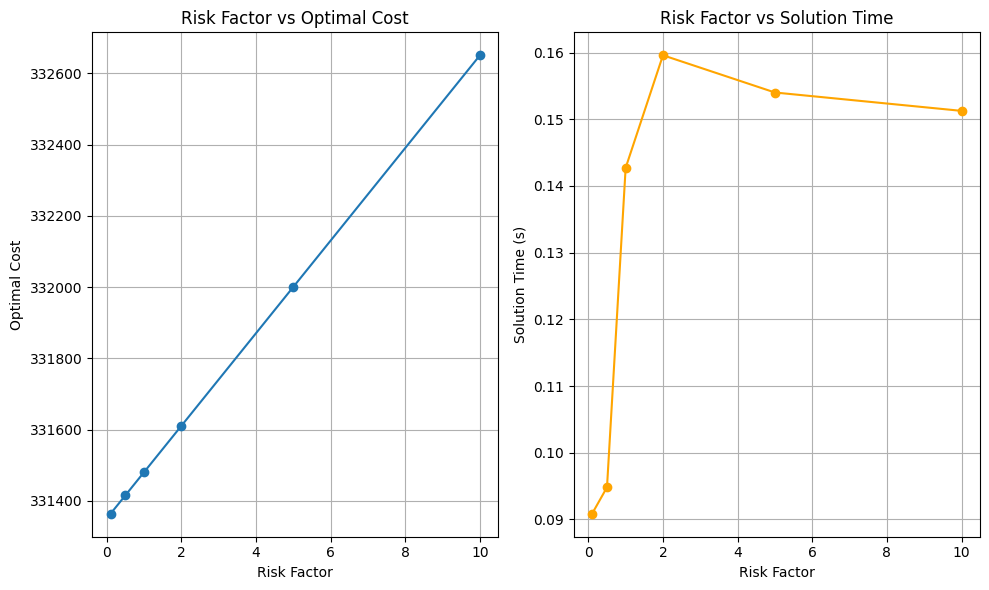

In [ ]:
# Risk factors to test
risk_factors = [0.1, 0.5, 1, 2, 5, 10]

# Store results
optimal_values = []
solution_times = []

# Solve for each risk factor
for rf in risk_factors:
    start_time = time.time()

    # Solve the model with the updated risk factor
    results, optimal_value, _, _, _, model = personnel_allocation_with_base_limit(
        I, J, personnel_types, costs, availability, requirements, capacities, distances, risks,
        travel_cost_factor=1, risk_factor=rf, M=1000, K=10, L=3
    )

    end_time = time.time()

    # Save results
    optimal_values.append(optimal_value)
    solution_times.append(end_time - start_time)

# Plot results
plt.figure(figsize=(10, 6))

# Plot optimal values
plt.subplot(1, 2, 1)
plt.plot(risk_factors, optimal_values, marker='o')
plt.title('Risk Factor vs Optimal Cost')
plt.xlabel('Risk Factor')
plt.ylabel('Optimal Cost')
plt.grid()

# Plot solution times
plt.subplot(1, 2, 2)
plt.plot(risk_factors, solution_times, marker='o', color='orange')
plt.title('Risk Factor vs Solution Time')
plt.xlabel('Risk Factor')
plt.ylabel('Solution Time (s)')
plt.grid()

plt.tight_layout()
plt.show()


As expected, the **optimal cost increases** steadily as the **risk factor rises.** This is **intuitive** because a **higher risk factor directly amplifies** the **weight of the risk component** in the objective function. Consequently, the model prioritizes solutions that minimize risk, but at a greater cost. The graph shows a perfectly linear relationship, indicating that the risk factor has a proportional effect on the total cost.

The solution time exhibits variability with different values of the risk factor. While the optimal cost follows a predictable trend, the time required to solve the model fluctuates. This is likely due to the solver exploring different parts of the solution space for each instance.

## **Conclusions**

The linear optimization model developed to address the deployment of medical personnel during the 2014 Ebola outbreak demonstrates the effectiveness of structured decision-making in humanitarian crises. By minimizing deployment costs while adhering to personnel requirements, hospital capacities, and logistical constraints, the model ensures an efficient allocation of resources to the most affected areas. The inclusion of binary variables and sensitivity analyses highlights the flexibility and robustness of the approach, accommodating real-world complexities such as route prioritization and risk management. The results underline the importance of optimization in enhancing emergency response capabilities and resource allocation under constrained conditions.